In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
from tqdm import tqdm 
import datetime

In [6]:
factor_path = "/Users/shezihua/Documents/MAFM/2022-2023 Summer/MAFS 6100L/SummerIndependentProject/factor/"

futureCodeList = ['JBF', 'QWF', 'HCF', 'DBF', 'EHF', 'IPF', 'IIF', 'QXF', 'PEF', 'NAF']
stockCodeList = ['3443', '2388', '2498', '2610', '1319', '3035', '3006', '2615', '5425', '3105']

data_clean_path = '/Users/shezihua/Documents/MAFM/2022-2023 Summer/MAFS 6100L/SummerIndependentProject/dataCleaned/'

In [7]:
futureCode = futureCodeList[4]
stockCode = stockCodeList[4]

stock = pd.read_csv(data_clean_path + futureCode + "-" + stockCode + "/stock.csv.gz", compression='gzip', index_col=0)
future = pd.read_csv(data_clean_path + futureCode + "-" + stockCode + "/future.csv.gz", compression='gzip', index_col=0)
spread = np.log(stock['price']) - np.log(future['midQ'])
spread = pd.DataFrame(spread)
spread.columns = ['spread']
feature = pd.read_csv(factor_path + futureCode + "-" + stockCode + "/factor.csv.gz", compression='gzip', index_col=0)

pool = pd.DataFrame()
pool.index = stock.index
pool['SP1'] = stock['SP1']
pool['BP1'] = stock['BP1']
pool['askPrice1'] = future['askPrice1']
pool['bidPrice1'] = future['bidPrice1']
pool['spread'] = spread['spread']
pool.index = pd.to_datetime(pool.index)

trade = pd.DataFrame()
trade.index = pool.index
trade['spread'] = pool['spread']
trade['signal'] = 0
trade['cap'] = 0
trade['pnl'] = 0
trade.index = pd.to_datetime(trade.index)

In [38]:
day_list = np.unique(pool.index.date)
train_period = 3
PnL = np.array([0])

for i in tqdm(range(len(day_list) - train_period)[-30:]):
    train_start_time = trade.index >= pd.to_datetime(str(day_list[i]) + ' 09:00:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
    train_end_time = trade.index <= pd.to_datetime(str(day_list[i + train_period - 1]) + ' 13:30:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
    train = trade[train_start_time & train_end_time]
    test_start_time = trade.index >= pd.to_datetime(str(day_list[i + train_period]) + ' 09:00:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
    test_end_time = trade.index <= pd.to_datetime(str(day_list[i + train_period]) + ' 13:30:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
    test = trade[test_start_time & test_end_time]

    current_pool = pool[test_start_time & test_end_time]
    today_stock = stock[test_start_time & test_end_time]
    today_future = future[test_start_time & test_end_time]

    mean = np.mean(train['spread'])
    std = np.std(train['spread'])

    upper = mean + 1.5 * std
    lower = mean - 1.5 * std

    for tick_idx in (range(len(test.index))): 
        current_data = test[0:tick_idx + 1]

        if tick_idx != len(test.index) - 1:
            # long spread
            if test.loc[test.index[tick_idx]]['spread'] <= lower: 
                if np.sum(current_data['signal']) == 0: 
                    lead = 1
                    while (today_stock[tick_idx + lead : tick_idx + lead + 1]['SP1'][0] > today_stock[tick_idx : tick_idx + 1]['SP1'][0]) and ((tick_idx + lead) < len(test.index) - 1):
                        lead = lead + 1
                    test.at[test.index[tick_idx + lead], 'signal'] = 1
                    test.at[test.index[tick_idx + lead], 'cap'] = today_stock[tick_idx + lead : tick_idx + lead + 1]['SP1'][0] * 2 - today_future[tick_idx + lead : tick_idx + lead + 1]['bidPrice1'][0]

            # back to mean
            elif test.loc[test.index[tick_idx]]['spread'] >= mean: 
                if np.sum(current_data['signal']) == 1: 
                    lead = 1
                    while (today_stock[tick_idx + lead : tick_idx + lead + 1]['BP1'][0] < today_stock[tick_idx : tick_idx + 1]['BP1'][0]) and ((tick_idx + lead) < len(test.index) - 1):
                        lead = lead + 1
                    test.at[test.index[tick_idx], 'signal'] = -1
                    test.at[test.index[tick_idx], 'cap'] = - today_stock[tick_idx + lead : tick_idx + lead + 1]['BP1'][0] * 2 + today_future[tick_idx + lead : tick_idx + lead + 1]['askPrice1'][0]
                    test.at[test.index[tick_idx], 'pnl'] = np.sum(current_data['cap']) #+ trade.loc[test.index[tick_idx]]['cap']

            # short spread
            elif test.loc[test.index[tick_idx]]['spread'] >= upper: 
                if np.sum(current_data['signal']) == 0: 
                    lead = 1
                    while (today_stock[tick_idx + lead : tick_idx + lead + 1]['BP1'][0] < today_stock[tick_idx : tick_idx + 1]['BP1'][0]) and ((tick_idx + lead) < len(test.index) - 1):
                        lead = lead + 1
                    test.at[test.index[tick_idx], 'signal'] = -1
                    test.at[test.index[tick_idx], 'cap'] = - today_stock[tick_idx + lead : tick_idx + lead + 1]['BP1'][0] * 2 + today_future[tick_idx + lead : tick_idx + lead + 1]['askPrice1'][0]

            # back to mean 
            elif test.loc[test.index[tick_idx]]['spread'] <= mean: 
                if np.sum(current_data['signal']) == -1: 
                    lead = 1
                    while (today_stock[tick_idx + lead : tick_idx + lead + 1]['SP1'][0] > today_stock[tick_idx : tick_idx + 1]['SP1'][0]) and ((tick_idx + lead) < len(test.index) - 1):
                        lead = lead + 1
                    test.at[test.index[tick_idx], 'signal'] = 1
                    test.at[test.index[tick_idx], 'cap'] = today_stock[tick_idx + lead : tick_idx + lead + 1]['SP1'][0] * 2 - today_future[tick_idx + lead : tick_idx + lead + 1]['bidPrice1'][0]
                    test.at[test.index[tick_idx], 'pnl'] = np.sum(current_data['cap'])# + trade.loc[test.index[tick_idx]]['cap']

            else: 
                pass
        
        else:
            if np.sum(current_data['signal']) == 1: 
                test.at[test.index[tick_idx], 'signal'] = -1
                test.at[test.index[tick_idx], 'cap'] = - current_pool.iloc[tick_idx]['BP1'] * 2 + current_pool.iloc[tick_idx]['askPrice1']
                test.at[test.index[tick_idx], 'pnl'] = np.sum(current_data['cap']) #+ trade.loc[test.index[tick_idx]]['cap']
            elif np.sum(current_data['signal']) == -1: 
                test.at[test.index[tick_idx], 'signal'] = 1
                test.at[test.index[tick_idx], 'cap'] = current_pool.iloc[tick_idx]['SP1'] * 2 - current_pool.iloc[tick_idx]['bidPrice1']
                test.at[test.index[tick_idx], 'pnl'] = np.sum(current_data['cap']) #+ trade.loc[test.index[tick_idx]]['cap']
            else:
                pass
    
    
    PnL = np.append(PnL, test[test['pnl'] != 0]['pnl'] + PnL[-1])

100%|██████████| 30/30 [01:08<00:00,  2.27s/it]


In [39]:
PnL

array([    0,    45,   150,   220,   240,   260,   350,   400,   490,
         540,   570,   590,   630,   670,   690,   740,   760,   810,
         840,   890,   900,   910,   950,   980,  1040,  1050,  1060,
        1140,  1200,  1265,  1285,  1335,  1445,  1525,  1620,  1690,
        1740,  1820,  1870,  1900,  1930,  1960,  1990,  2040,  2155,
        2225,  2235,  2275, -2660,  2330,  2380, -2570, -2520, -2465,
       -2440, -2430, -2390, -2330, -2290, -2250, -2200, -2150, -2130,
       -2120, -2090, -2070, -2060, -2010, -2000, -1980, -1890, -1860,
       -1820, -1780, -1770, -1760, -1740, -1690, -1620, -1540, -1500,
       -1450, -1400, -1360, -1310, -1270, -1260, -1220, -1150, -1110,
       -1100, -1070, -1060, -1010,  -970,  -920,  -890,  -860,  -840,
        -810,  -760,  -750,  -740,  -710,  -660,  -630,  -610,  -570,
        -560,  -530,  -510,  -480,  -470,  -430,  -420,  -370,  -330,
        -330,  -300,  -270,  -230,  -200,  -180,  -160,  -130,  -120,
        -110,   -90,

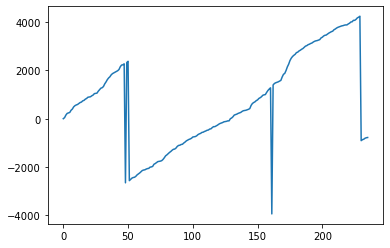

In [40]:
plt.plot(PnL)

# Find where the lead time can be arbitrage

In [69]:
day_list = np.unique(pool.index.date)
train_period = 3
PnL = np.array([0])

for i in tqdm(range(len(day_list) - train_period)[-30:]):
    train_start_time = trade.index >= pd.to_datetime(str(day_list[i]) + ' 09:00:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
    train_end_time = trade.index <= pd.to_datetime(str(day_list[i + train_period - 1]) + ' 13:30:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
    train = trade[train_start_time & train_end_time]
    test_start_time = trade.index >= pd.to_datetime(str(day_list[i + train_period]) + ' 09:00:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
    test_end_time = trade.index <= pd.to_datetime(str(day_list[i + train_period]) + ' 13:30:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
    test = trade[test_start_time & test_end_time]

    current_pool = pool[test_start_time & test_end_time]
    today_stock = stock[test_start_time & test_end_time]
    today_future = future[test_start_time & test_end_time]

    mean = np.mean(train['spread'])
    std = np.std(train['spread'])

    upper = mean + 1.5 * std
    lower = mean - 1.5 * std

    for tick_idx in (range(len(test.index))): 
        current_data = test[0:tick_idx + 1]

        if tick_idx != len(test.index) - 1:
            # long spread
            if test.loc[test.index[tick_idx]]['spread'] <= lower: 
                if np.sum(current_data['signal']) == 0: 
                    lead = 1
                    while (today_stock[tick_idx + lead : tick_idx + lead + 1]['SP1'][0] > today_stock[tick_idx : tick_idx + 1]['SP1'][0]) and ((tick_idx + lead) < tick_idx + 3):
                        lead = lead + 1
                    # if np.log(today_stock[tick_idx + lead : tick_idx + lead + 1]['SP1'][0]) - np.log(today_future[tick_idx + lead : tick_idx + lead + 1]['bidPrice1'][0]) <= lower:
                    test.at[test.index[tick_idx + lead], 'signal'] = 1
                    test.at[test.index[tick_idx + lead], 'cap'] = today_stock[tick_idx + lead : tick_idx + lead + 1]['SP1'][0] * 2 - today_future[tick_idx + lead : tick_idx + lead + 1]['bidPrice1'][0]

            # back to mean
            elif test.loc[test.index[tick_idx]]['spread'] >= mean: 
                if np.sum(current_data['signal']) == 1: 
                    lead = 1
                    while (today_stock[tick_idx + lead : tick_idx + lead + 1]['BP1'][0] < today_stock[tick_idx : tick_idx + 1]['BP1'][0]) and ((tick_idx + lead) < tick_idx + 3):
                        lead = lead + 1
                    # if np.log(today_stock[tick_idx + lead : tick_idx + lead + 1]['BP1'][0]) - np.log(today_future[tick_idx + lead : tick_idx + lead + 1]['askPrice1'][0]) >= mean:
                    test.at[test.index[tick_idx], 'signal'] = -1
                    test.at[test.index[tick_idx], 'cap'] = - today_stock[tick_idx + lead : tick_idx + lead + 1]['BP1'][0] * 2 + today_future[tick_idx + lead : tick_idx + lead + 1]['askPrice1'][0]
                    test.at[test.index[tick_idx], 'pnl'] = np.sum(current_data['cap']) #+ trade.loc[test.index[tick_idx]]['cap']

            # short spread
            elif test.loc[test.index[tick_idx]]['spread'] >= upper: 
                if np.sum(current_data['signal']) == 0: 
                    lead = 1
                    while (today_stock[tick_idx + lead : tick_idx + lead + 1]['BP1'][0] < today_stock[tick_idx : tick_idx + 1]['BP1'][0]) and ((tick_idx + lead) < tick_idx + 3):
                        lead = lead + 1
                    #if np.log(today_stock[tick_idx + lead : tick_idx + lead + 1]['BP1'][0]) - np.log(today_future[tick_idx + lead : tick_idx + lead + 1]['askPrice1'][0]) >= upper:
                    test.at[test.index[tick_idx], 'signal'] = -1
                    test.at[test.index[tick_idx], 'cap'] = - today_stock[tick_idx + lead : tick_idx + lead + 1]['BP1'][0] * 2 + today_future[tick_idx + lead : tick_idx + lead + 1]['askPrice1'][0]

            # back to mean 
            elif test.loc[test.index[tick_idx]]['spread'] <= mean: 
                if np.sum(current_data['signal']) == -1: 
                    lead = 1
                    while (today_stock[tick_idx + lead : tick_idx + lead + 1]['SP1'][0] > today_stock[tick_idx : tick_idx + 1]['SP1'][0]) and ((tick_idx + lead) < tick_idx + 3):
                        lead = lead + 1
                    #if np.log(today_stock[tick_idx + lead : tick_idx + lead + 1]['SP1'][0]) - np.log(today_future[tick_idx + lead : tick_idx + lead + 1]['bidPrice1'][0]) <= mean:
                    test.at[test.index[tick_idx], 'signal'] = 1
                    test.at[test.index[tick_idx], 'cap'] = today_stock[tick_idx + lead : tick_idx + lead + 1]['SP1'][0] * 2 - today_future[tick_idx + lead : tick_idx + lead + 1]['bidPrice1'][0]
                    test.at[test.index[tick_idx], 'pnl'] = np.sum(current_data['cap'])# + trade.loc[test.index[tick_idx]]['cap']

            else: 
                pass
        
        else:
            if np.sum(current_data['signal']) == 1: 
                test.at[test.index[tick_idx], 'signal'] = -1
                test.at[test.index[tick_idx], 'cap'] = - current_pool.iloc[tick_idx]['BP1'] * 2 + current_pool.iloc[tick_idx]['askPrice1']
                test.at[test.index[tick_idx], 'pnl'] = np.sum(current_data['cap']) #+ trade.loc[test.index[tick_idx]]['cap']
            elif np.sum(current_data['signal']) == -1: 
                test.at[test.index[tick_idx], 'signal'] = 1
                test.at[test.index[tick_idx], 'cap'] = current_pool.iloc[tick_idx]['SP1'] * 2 - current_pool.iloc[tick_idx]['bidPrice1']
                test.at[test.index[tick_idx], 'pnl'] = np.sum(current_data['cap']) #+ trade.loc[test.index[tick_idx]]['cap']
            else:
                pass
    
    
    PnL = np.append(PnL, test[test['pnl'] != 0]['pnl'] + PnL[-1])

100%|██████████| 30/30 [01:04<00:00,  2.16s/it]


In [70]:
PnL

array([    0,    45,   165,   235,   255,   275,   365,   415,   505,
         555,   585,   605,   665,   705,   725,   775,   795,   835,
         865,   915,   925,   935,  1015,  1045,  1105,  1115,  1125,
        1205,  1265,  1330,  1350,  1400,  1560,  1640,  1735,  1805,
        1855,  1935,  1985,  2015,  2045,  2075,  2105,  2155,  2270,
        2340,  2350,  2390, -2540,  2450, -2485,  2500,  2550,  2600,
        2655,  2680,  2690,  2730,  2790,  2830,  2870,  2920,  2970,
        3010,  3020,  3050,  3070,  3100,  3150,  3160,  3180,  3270,
        3340,  3380,  3420,  3430,  3460,  3480,  3530,  3650,  3780,
        3840,  3890,  3940,  3980,  4030,  4070,  4080,  4120,  4190,
        4230,  4250,  4280,  4290,  4340,  4380,  4430,  4460,  4480,
        4510,  4530,  4560,  4610,  4620,  4630,  4660,  4710,  4740,
        4760,  4800,  4820,  4870,  4890,  4920,  4930,  4970,  4980,
        5030,  5070,  5070,  5100,  5130,  5170,  5200,  5220,  5260,
        5290,  5300,

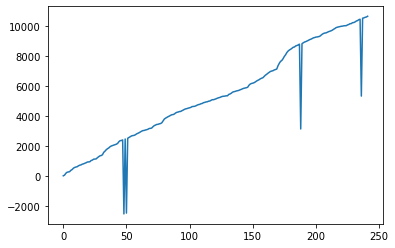

In [71]:
plt.plot(PnL)

# model

In [ ]:
day_list = np.unique(pool.index.date)
train_period = 3
PnL = np.array([0])

for i in tqdm(range(len(day_list) - train_period)[-30:]):
    train_start_time = trade.index >= pd.to_datetime(str(day_list[i]) + ' 09:00:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
    train_end_time = trade.index <= pd.to_datetime(str(day_list[i + train_period - 1]) + ' 13:30:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
    train = trade[train_start_time & train_end_time]
    test_start_time = trade.index >= pd.to_datetime(str(day_list[i + train_period]) + ' 09:00:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
    test_end_time = trade.index <= pd.to_datetime(str(day_list[i + train_period]) + ' 13:30:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
    test = trade[test_start_time & test_end_time]

    feature_train = feature[train_start_time & train_end_time]
    feature_test = feature[test_start_time & test_end_time]

    current_pool = pool[test_start_time & test_end_time]

    mean = np.mean(train['spread'])
    std = np.std(train['spread'])

    upper = mean + 1.5 * std
    lower = mean - 1.5 * std

    X_train = feature_train[feature_train.columns[0:-1]]
    y_train = feature_train['delta_spread']
    upper_quantile=0.85
    lower_quantile=0.15
    train_spread_upper = float(y_train.quantile(upper_quantile))
    train_spread_lower = float(y_train.quantile(lower_quantile))

    model_ols = LinearRegression()
    model_ols.fit(X_train, y_train)
    
    X_test = feature_test[feature_test.columns[0:-1]]
    y_test = feature_test['delta_spread']

    y_test_pred = model_ols.predict(X_test)

    for tick_idx in (range(len(test.index))): 
        current_data = test[0:tick_idx + 1]

        if tick_idx != len(test.index) - 3:

            # long spread
            if test.loc[test.index[tick_idx]]['spread'] <= lower: 
                if np.sum(current_data['signal']) == 0: 
                    if y_test_pred[tick_idx] < train_spread_lower:
                        test.at[test.index[tick_idx+1], 'signal'] = 1
                        test.at[test.index[tick_idx+1], 'cap'] = current_pool.iloc[tick_idx]['SP1'] * 2 - current_pool.iloc[tick_idx]['bidPrice1']

            # back to mean
            elif test.loc[test.index[tick_idx]]['spread'] >= mean: 
                if np.sum(current_data['signal']) == 1: 
                    if y_test_pred[tick_idx] > train_spread_upper:
                        test.at[test.index[tick_idx+1], 'signal'] = -1
                        test.at[test.index[tick_idx+1], 'cap'] = - current_pool.iloc[tick_idx]['BP1'] * 2 + current_pool.iloc[tick_idx]['askPrice1']
                        test.at[test.index[tick_idx+1], 'pnl'] = np.sum(current_data['cap']) #+ trade.loc[test.index[tick_idx]]['cap']

            # short spread
            elif test.loc[test.index[tick_idx]]['spread'] >= upper: 
                if np.sum(current_data['signal']) == 0: 
                    if y_test_pred[tick_idx] > train_spread_upper:
                        test.at[test.index[tick_idx+1], 'signal'] = -1
                        test.at[test.index[tick_idx+1], 'cap'] = - current_pool.iloc[tick_idx]['BP1'] * 2 + current_pool.iloc[tick_idx]['askPrice1']

            # back to mean 
            elif test.loc[test.index[tick_idx]]['spread'] <= mean: 
                if np.sum(current_data['signal']) == -1: 
                    if y_test_pred[tick_idx] < train_spread_lower:
                        test.at[test.index[tick_idx+1], 'signal'] = 1
                        test.at[test.index[tick_idx+1], 'cap'] = current_pool.iloc[tick_idx]['SP1'] * 2 - current_pool.iloc[tick_idx]['bidPrice1']
                        test.at[test.index[tick_idx+1], 'pnl'] = np.sum(current_data['cap'])# + trade.loc[test.index[tick_idx]]['cap']

            else: 
                pass
        
        else:
            pass
            #if np.sum(current_data['signal']) == 1: 
            #    test.at[test.index[tick_idx], 'signal'] = -1
            #    test.at[test.index[tick_idx], 'cap'] = - current_pool.iloc[tick_idx]['BP1'] * 2 + current_pool.iloc[tick_idx]['askPrice1']
            #    test.at[test.index[tick_idx], 'pnl'] = np.sum(current_data['cap']) #+ trade.loc[test.index[tick_idx]]['cap']
            #elif np.sum(current_data['signal']) == -1: 
            #    test.at[test.index[tick_idx], 'signal'] = 1
            #    test.at[test.index[tick_idx], 'cap'] = current_pool.iloc[tick_idx]['SP1'] * 2 - current_pool.iloc[tick_idx]['bidPrice1']
            #    test.at[test.index[tick_idx], 'pnl'] = np.sum(current_data['cap']) #+ trade.loc[test.index[tick_idx]]['cap']
            #else:
            #    pass
    
    
    PnL = np.append(PnL, test[test['pnl'] != 0]['pnl'] + PnL[-1])

plt.plot(PnL)